# Dev 01 Developing Code for CMEProcess

What are the recipe that we need?
- Write everything in pytorch and gpytorch
- Write up conditional mean operators
- Integrate Conditional Mean Operators into the problem

In [21]:
# Import packages
import gpytorch
import torch
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# import kernels
from gpytorch.kernels import RBFKernel

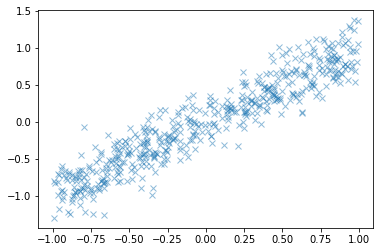

In [22]:
# Set up CMO Operators

# first simulate some naive X,Y

n = 500
y = np.random.uniform(-1, 1, n)
x = np.array([np.random.normal(loc=l, scale=0.2) for l in y])
plt.plot(y, x, "x", alpha=0.5)
plt.show()

In [36]:
# Set up kernel

# Ternsorise the input
x_ten = torch.tensor(x).float()
y_ten = torch.tensor(y).float()

# RBF Kernel
k_x = RBFKernel()
l_y = RBFKernel()

K = k_x(x_ten)
L = l_y(y_ten)

### Some basic operations with gpytorch kernel to remember
1. inv_matmul
    - Compuite its matrix product between its inverse and a right tensor component
2. add_diag
    - as regularisation
3. add_jitter 
    - stablising the problem

In [49]:
# Set up a function f of the following form

alphas = torch.randn((n,1))

fx = K.evaluate() @ alphas

In [70]:
# The corresponding CME of this f as a function of g is

L_nl = L.add_diag(torch.tensor(n*1e-3))
L_nl.inv_matmul(left_tensor=(K@alphas).T,right_tensor=L[:,0])

tensor([-5.0403], grad_fn=<InvMatmulBackward>)

# CMEProcess for 1 dimensional case

The set up of a CMEProcess is as follows:

$$g(y) = \int f(x) dP(x|y)$$

where 
$$f \sim GP(m, k)$$

then $g$ is also a GP with the following mean and covariances:
$$\bar{m}(y) = \mathbb{E}_{X|Y=y}[m(X)]$$
here we might have to assume $m \in \mathcal{H}_k$ for the CMO approximation to work.

The covariance is then:
$$\bar{\kappa}(y,y') = \mathbb{E}_{X|Y=y}\mathbb{E}_{X'|Y=y'}[k(X, X')]$$

since $k$ lives in the rkhs, we can use conditional mean operators to approximate the above quantitiy,

\begin{align}
\bar{\kappa}(y, y') &= l_{y, y_{1:n}}(L + n\lambda I)^{-1}K_{XX}(L + n\lambda I)^{-1}l_{y_{1:n}, y'} \\
                    &= l_{y, y_{1:n}}\Xi l_{y_{1:n}, y'}
\end{align}

Can we code this out now?

-------

### Inference task

Given two datasets, $\{x_i, y_i\}_{i=1}^n$ and $\{ z_j, g(y_j) \}_{j=1}^M$, everything can be written as Gaussians and we can use Gaussian conditioning to optimise our likelihood.

In [120]:
# Question 1: Is there a weay to represent the covariance of g in matrix form?

lmda = 1e-3

# Compute the central matrix
Xi_left = L.add_diag(torch.tensor(n*lmda)).inv_matmul(right_tensor=K.cholesky().evaluate())
Xi = Xi_left @ Xi_left.T

In [121]:
l_y(y_ten[[0]], y_ten).matmul(Xi) @ l_y(y_ten, y_ten[[0]]).evaluate()

tensor([[0.9333]], grad_fn=<MmBackward>)

In [122]:
holder_cov = torch.zeros((n, n))

In [123]:
holder_cov[0, 0] = l_y(y_ten[[0]], y_ten).matmul(Xi) @ l_y(y_ten, y_ten[[0]]).evaluate()

In [124]:
for i in range(n):
    for j in range(n):
        holder_cov[i, j] = l_y(y_ten[[i]], y_ten).matmul(Xi) @ l_y(y_ten, y_ten[[j]]).evaluate()

In [129]:
# Test 2

L.matmul(Xi)@L.evaluate()

tensor([[0.9333, 0.4236, 0.9305,  ..., 0.8533, 0.9271, 0.5672],
        [0.4236, 0.8887, 0.3877,  ..., 0.2412, 0.3701, 0.8759],
        [0.9305, 0.3877, 0.9321,  ..., 0.8741, 0.9310, 0.5286],
        ...,
        [0.8533, 0.2412, 0.8741,  ..., 0.9125, 0.8830, 0.3558],
        [0.9271, 0.3701, 0.9309,  ..., 0.8830, 0.9309, 0.5091],
        [0.5672, 0.8759, 0.5286,  ..., 0.3558, 0.5091, 0.9122]],
       grad_fn=<MmBackward>)


Therefore we can conclude that the vector $g(\bar{y})$ has the following distribution:

$$g(\bar{y}) \sim N(0, L \Xi L)$$

and the corresponding observed values $z$ will distribute as:

$$\bar{z} \sim N(0, L\Xi L + \sigma^2)$$

In [131]:
# Thus we can do Gaussian Conditioning


# Simulation studies

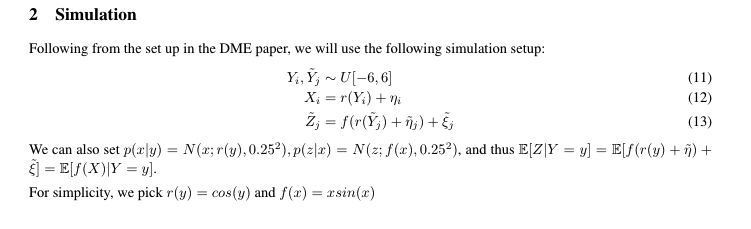

In [164]:
n = 100
m = 500

y = np.random.uniform(-6, 6, n)
y_tilde = np.random.uniform(-6, 6, m)

eta = np.random.normal(loc=0, scale=0.25, size=n)
eta_tilde = np.random.normal(loc=0, scale=0.25, size=m)
xi_tilde = np.random.normal(loc=0, scale=0.25, size=m)

r = lambda y: np.cos(y)
f = lambda x: x*np.sin(x)

x = r(y) + eta
z = f((r(y_tilde) + eta_tilde).reshape(-1,1)) + xi_tilde.reshape(-1,1)

# Dataset 1
D_1 = [x, y]
D_2 = [y_tilde, z]

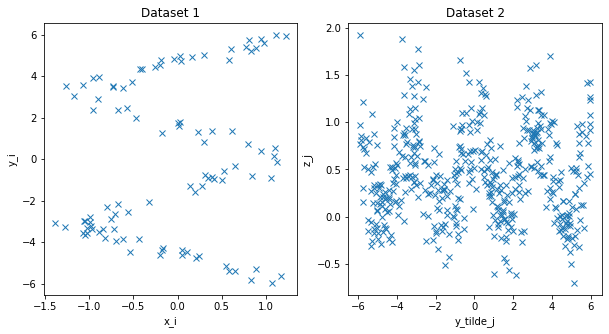

In [167]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(x, y, "x")
axes[0].set_title("Dataset 1")
axes[0].set_xlabel("x_i")
axes[0].set_ylabel("y_i")

axes[1].plot(y_tilde, z, "x")
axes[1].set_title("Dataset 2")
axes[1].set_xlabel("y_tilde_j")
axes[1].set_ylabel("z_j")

plt.show()

## Think about how to write that code for CMEProcess



In [169]:
# Right now the simplest way to solve this is to set up 
# the likelihood manually and use torch to optimise everything.

# Idea: Optimise the likelihood for z first. Obtain hyperparameters, then compute the posterior of f.
# So we need to set up the GP for g first.

# Gaussian Processes for g



gpytorch.likelihoods.gaussian_likelihood.GaussianLikelihood